In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
objpoints = []
imgpoints = []

nx,ny = (9,6)

# initialize three columns (x,y,z) with zeros
# (0,0,0), (1,0,0), (2,0,0) ...
objp = np.zeros((ny*nx,3), np.float32)

# Use mgrid to generate coordinates
# reshape back into two columns
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Camera Calibration

Because cameras lenses distort the light that passes through them (especially around the edges), calibration is needed to adjust for this distortion. OpenCV has several functions to make this easy, and it really only needs to be done once. First, we need multiple images of a chessboard pattern from several different angles. Then we can run them through the following procedure.

## Corner Detection

Convert to grayscale and run `cv2.findChessboardCorners` on all of the chessboard images in the calibration folder, saving the object points and image points. The Object Points (`objpoints`) we created earlier, represent the 9x6 corners of the chessboard. These are appended each time we add image points. The image points are the image x,y pixel locations of each corner.

In [3]:
calibration_images = glob.glob('camera_cal/calibration*.jpg')

for fname in calibration_images:
    img = mpimg.imread(fname)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

## Undistort

Convert to grayscale and run cv2.calibrateCamera using the discovered object points and image points. Finally, undistort the image using cv2.undistort.

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

### Example of Undistort

Here I take one example chessboard image and apply the undistort function on it.

In [5]:
img = mpimg.imread(calibration_images[1])
undistorted = cal_undistort(img, objpoints, imgpoints)

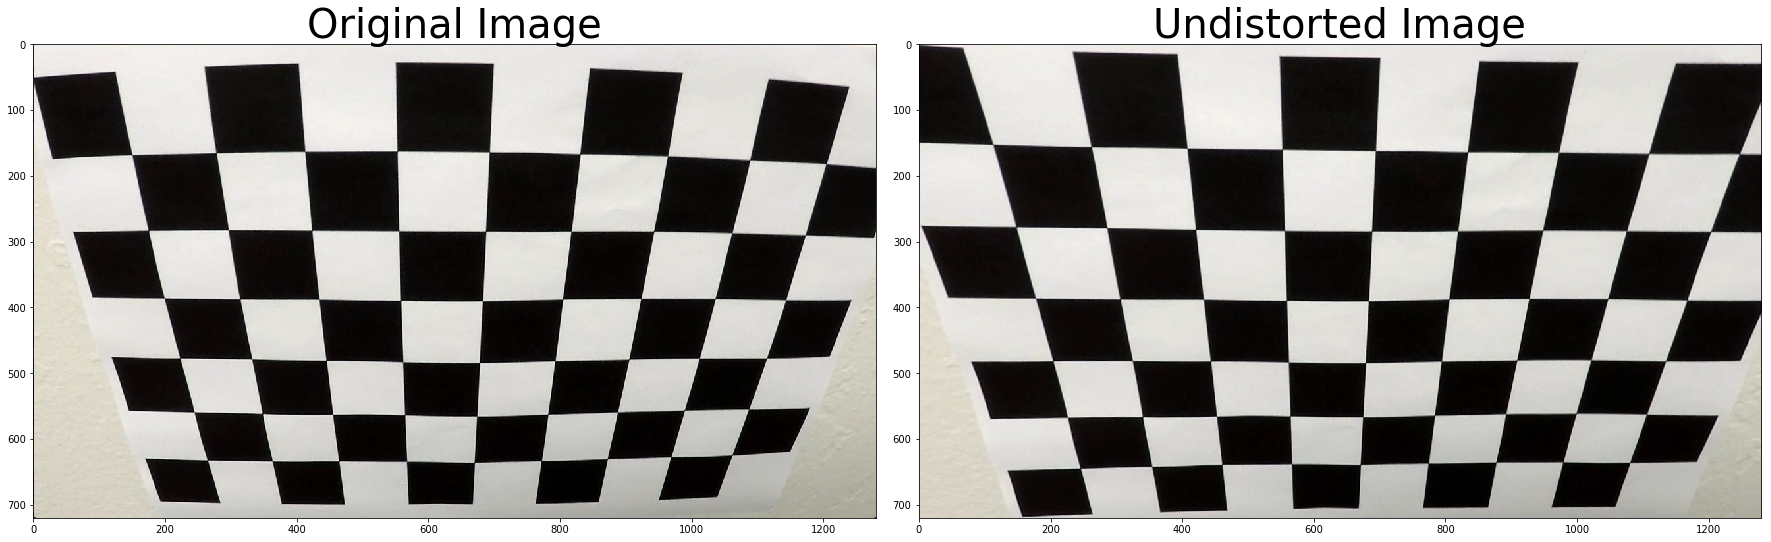

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Color and Gradient Thresholds

### HLS Threshold

By exploring different color spaces, like HLS, we can more accurately find lane lines in a variety of conditions. The Saturation channel in HLS does well to highlight lane lines, even in shadow. With a well-chosen threshold, we can adeptly pick out lane lines.

In [7]:
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    S = hls[:,:,2]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(S) # placeholder line
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output


### Sobel Filter

The Sobel filter works very well to detect and emphasize edges in the image. It can operate in either the x or the y direction.

In [8]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    o = {"x" : 0, "y" : 0}
    o[orient] += 1
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, o['x'], o['y'], ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

### The Overall Magnitude of the Gradient

Although the x-gradient clearly shows the lane lines, we can detect the lines in the y-gradient as well, so we can apply a threshold to the overall magnitude of the gradient, in both x and y.

In [9]:
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = {"x" : cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel), "y" : cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) }
    mag = np.sqrt(np.power(sobel["x"],2) + np.power(sobel["y"],2))
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

### Directional Threshold
Since lane lines are basically vertical, a directional gradient helps isolate them even further, as taking the gradient in the x direction emphasizes edges that are near vertical.

In [10]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = {"x" : cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel), "y" : cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) }
    direction = np.arctan2(np.absolute(sobel['y']), np.absolute(sobel['x']))
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

### Examples of Color and Gradient Thresholds

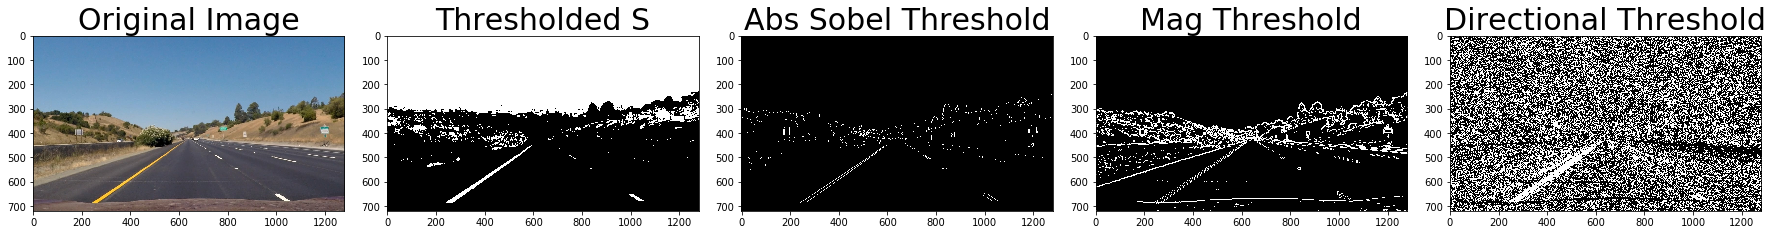

In [11]:
image = mpimg.imread('test_images/straight_lines1.jpg')

# Plot the result
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_select(image, thresh=(90, 255)), cmap='gray')
ax2.set_title('Thresholded S', fontsize=30)
ax3.imshow(abs_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(50, 200)), cmap='gray')
ax3.set_title('Abs Sobel Threshold', fontsize=30)
ax4.imshow(mag_threshold(image, sobel_kernel=9, mag_thresh=(30,100)), cmap='gray')
ax4.set_title('Mag Threshold', fontsize=30)
ax5.imshow(dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3)), cmap='gray')
ax5.set_title('Directional Threshold', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combinations

A combination of absolute Sobel and the saturation channel seem to bring out the lane lines reasonably well. I'm using `sobel_kernel=3, thresh=(50, 200)` for the absolute Sobel, and `thresh=(90, 255)` for the S channel. 

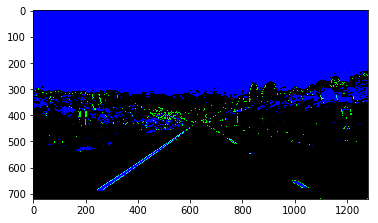

In [24]:
saturation = hls_select(image, thresh=(90, 255))
absobel = abs_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(50, 200))
magnitude = mag_threshold(image, sobel_kernel=9, mag_thresh=(30,100))
direction = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

# Stack each channel
color_binary = np.dstack(( np.zeros_like(saturation), absobel, saturation)) * 255

plt.imshow(color_binary)

# Perspective Transform

# Detect Lane Lines

# Determine Lane Curvature